# GPU Programming Lab
This lab is an introduction of GPU programming with cuda using python. The consists of 3 exercises and a homework. 

- <font color='red'><b> Write a detailed report, in the report section below, explaining what you have done, your observations and  conclusions. </b></font>
- <font color='red'><b> Make sure to write your name and your partner name (as registred in Halmstad University) in the name section below. </b></font>
    
- <font color='red'><b> You can do the lab in a group of a maximum of two students. </b></font>

- <font color='red'><b> Only one of the students upload the lab to the blackboard. </b></font>

# CUDA
CUDA is a parallel programming platform and an API that facilitates the access to the CUDA-Enabled GPU functuonality for general purpose computing. It allows speeding up the software by utilizing the GPU power for the parallelizable part of the computation. Many Deep Learning platforms like tenserflow, keras, pytorch and others, rely on CUDA for their computations.

## Common CUDA terminology:
- <b>Host:</b> The CPU
- <b>Device:</b> The GPU
- <b>Host Memory:</b> The system main memory
- <b>Device Memory:</b> The GPU onboard memory
- <b>kernel:</b> A function that runs on the Device

Threads are organized into a grid of blocks, where each block contains a subset of the threads that can cooperate using a block shared memory and can synchronize within each block.

<img src='https://drive.google.com/uc?id=1QzXBVWki0M80KKY_CPzQu1ivE3fAcf2U' width="50%" height="50%"></img>


Parallel portions of an application are executed on the device (GPU) as kernels, where an array of threads excutes each kernel. Each thread has an ID, by which it controls the portion of the data to excute the Kernel. All threads runs the same code on different portions of the data. Grids and Blocls can be organized as 1D, 2D, or 3D arrays. 

<img src='https://drive.google.com/uc?id=1vqh749XFQhfZwq7m7E-VXscBblh58mei' width="50%" height="50%"></img>






# Numba
CUDA is designed to work with C++, but in this Lab we will work with Numba; a Python JIT compiler that translates subsets of the code into machine code, and enables writing a parallel GPU algorithms in Python

## Numba installation


conda install numba

pip install numba

In [1]:
!pip install numba

In [ ]:
conda install cudatoolkit

# Kernel 
- A Kernel is declared as a function with @cuda.jit decorator.
- A Kernel function cannot have a return value and manages outputs as input-output arrays

In [8]:
import numpy as np
import math
import numba as nb
from numba import cuda
from skimage import data
import matplotlib.pyplot as plt
import cv2
import time

In [2]:
print(cuda.gpus)

<Managed Device 0>


In [3]:
# kernel decleration
@cuda.jit
def my_kernel(io_array):
    # code here
    pass


To invoc a kernal you have to specify number of blocks in the grid, and the number of threads per block. This can be done by specifying the number of threads per block and calculating how many blocks are required in the grid based on the size of the data.

<font color=red>Important note: In the case that the data size is not divisable by the the number of thread per block, we take the ceiling of the number to reserve an extra block for the remaining part of the data. So the threads in the last block will not be fully occupied.</font>

In [4]:
# kernel invocation
data = np.ones(256)

threadsperblock = 32
blockspergrid = math.ceil(len(data)/threadsperblock)

my_kernel[blockspergrid, threadsperblock](data)


C:\Users\nkill\anaconda3\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


# Example 1: Element-wise operation

The following kernel takes 1D array as input and computes the element-wise cube-root x^(1/3) for each element in the array. This an example of an arbitrary costy operation.

- pos: holds the position in the data on which the thread will work.
- Always check if the position exceeds the length of the data for the sake of cases when the data length is not devisable by the number of threads per block.

<img src='https://drive.google.com/uc?id=1AndzjaLH-Lc7N4cg1Ue_zEB3EyJni89N' width="50%" height="50%"></img>

Read the code below and compute the position of the thread on which it will do the computation in the output array.

In [5]:
# kernel decleration
@cuda.jit
def my_kernel(io_array):
    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    bx = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    
    # compute flattened index inside the array
    # compute the correct pos value based on the tread index and the block index and the block width
    pos = (bx * bw) + tx

    if pos < io_array.size:
        io_array[pos] = io_array[pos]**(1/3)
        

# kernel invocation
data =  np.array(list(range(1, 2049)))
print('Input Size:', data.shape)
print('Input:',data)

threadsperblock = 256
blockspergrid = math.ceil(data.shape[0] / threadsperblock)
my_kernel[blockspergrid, threadsperblock](data)
print('Output Size:', data.shape)
print('Output:',data)

Input Size: (2048,)
Input: [   1    2    3 ... 2046 2047 2048]
Output Size: (2048,)
Output: [ 1  1  1 ... 12 12 12]


C:\Users\nkill\anaconda3\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [6]:
data = np.ones(10000000)*27
%timeit np.cbrt(data)

780 ms ± 86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
data = np.ones(10000000)*27
threadsperblock = 1024
blockspergrid = math.ceil(data.shape[0] / threadsperblock)
%timeit my_kernel[blockspergrid, threadsperblock](data)

C:\Users\nkill\anaconda3\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


114 ms ± 6.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Exercise 1: Image Transpose

The transpose of a matrix is an operator which flips a matrix over its diagonal; that is, it switches the row and column indices of the matrix.

image.png


First let's grab some data!

Some notes to pay attention to:

1.  now we work with 2D array (i.e, image), so wewill have 2D blocks
2.  kernel function does not return an output, so the output needs to passed as one of the inputs 




In [13]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [11]:
# thread per block
TPB = 32
moon = data.moon().astype(np.float32) / 255

@cuda.jit
def my_tanspose_kernel(input, output):
    tile = cuda.shared.array(shape=(TPB, TPB), dtype=input.dtype)

    # Thread id in a 2D block
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    # Block id in a 2D grid
    bx = cuda.blockIdx.x * cuda.blockDim.x
    by = cuda.blockIdx.y * cuda.blockDim.y

    # absolute position
    x = bx + tx
    y = by + ty

    if y < input.shape[0] and x < input.shape[1]:
        tile[tx, ty] = input[y, x]  # Swap tx and ty indices
    cuda.syncthreads()
    if y < output.shape[0] and x < output.shape[1]:
        output[x, y] = tile[tx, ty]

In [12]:
def transposeImg(image):
    image_global_mem = cuda.to_device(image)
    # Allocate memory on the device for the result (Note the shape of the output)
    out_global_mem2 = cuda.device_array(image.shape)

    # Configure the blocks
    # Specify how many threads per block
    threadsperblock = (TPB, TPB)

    # Calculate how many blocks are required
    blockspergrid_x = math.ceil(image.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(image.shape[1] / threadsperblock[1])
    blockspergrid = (blockspergrid_y, blockspergrid_x)  # Flip the grid dimensions

    # Start the kernel based on the calculated grid
    my_tanspose_kernel[blockspergrid, threadsperblock](image_global_mem, out_global_mem2)

    # Copy the result back to the host
    out_image = out_global_mem2.copy_to_host()
    return out_image

transpose_moon = transposeImg(moon)


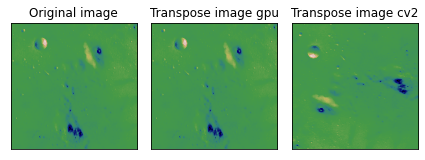

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(moon, cmap="gist_earth")
ax2.imshow(transpose_moon.T, cmap="gist_earth")  # Flip indices using .T
ax3.imshow(cv2.transpose(moon), cmap="gist_earth")
ax1.set(title="Original image")
ax2.set(title="Transpose image gpu")
ax3.set(title="Transpose image cv2")
for ax in (ax1, ax2, ax3):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
fig.tight_layout()
plt.show()


## Exercise 2: Image Enhancement

To end this tutorial, let's craft a 2D kernel to apply [logarithmic correction](https://scikit-image.org/docs/stable/api/skimage.exposure.html#skimage.exposure.adjust_log) to an image.

Given an image $I(x, y)$ with values between 0 and 1, the log-corrected image is given by

$$I_c(x, y) = \gamma \log_2 (1 + I(x, y))$$


In [14]:
#todo: write kernel declaration
import math

@cuda.jit
def my_logcorr_kernel(input, scaler, output):
    # Thread id in a 2D block
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    # Block id in a 2D grid
    bx = cuda.blockIdx.x * cuda.blockDim.x
    by = cuda.blockIdx.y * cuda.blockDim.y

    # compute flattened index inside the array
    pos_x = bx + tx
    pos_y = by + ty
    
    if pos_x < input.shape[0] and pos_y < input.shape[1]:
        output[pos_x, pos_y] = scaler * math.log2(1 + input[pos_x, pos_y])


In [15]:
def logCorrImg(image, scaler=1.0):
    # Allocate memory on the device for the result
    image_global_mem = cuda.to_device(image)
    output_global_mem = cuda.device_array(image.shape, dtype=np.float32)
    
    # Specify how many threads per block
    threadsperblock = (TPB, TPB)

    # Calculate how many blocks are required
    blockspergrid_x = math.ceil(image.shape[0]/threadsperblock[0])
    blockspergrid_y = math.ceil(image.shape[1]/threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    # Start the kernel
    my_logcorr_kernel[blockspergrid, threadsperblock](image_global_mem, scaler, output_global_mem)
    
    # Copy the result back to the host
    result = output_global_mem.copy_to_host()
    
    return result

logcor_moon = logCorrImg(moon, scaler=1.0)

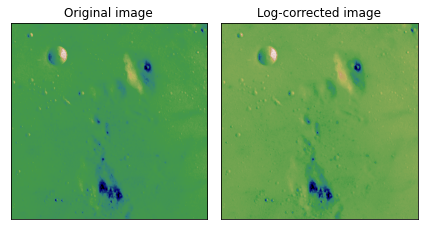

In [16]:
#visulaize orginal and corrected image
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(moon, cmap="gist_earth")
ax2.imshow(logcor_moon, cmap="gist_earth")
ax1.set(title="Original image")
ax2.set(title="Log-corrected image")
for ax in (ax1, ax2):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
fig.tight_layout()

## Exercise 3: Matrix Multiplication

In matrix multiplication, every kernel will be reponsible of computing one element of the output matrix. It reads one row from the first matrix (A) and one column form the second matrix (B) and computes the dot product of these two vectors and place it in the corresponding cell in the output matrix (C) as shown in the following figure.

<img src='https://drive.google.com/uc?id=16EMuj46QLdwKmIDPU0P6AepZ9SNssb2s' width="50%" height="50%"></img>

Write a kernel to do the multiplication of two matrices.

In [17]:
# CUDA kernel
@cuda.jit
def mat_mul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    # get the 2D position of the thread in which it will compute the dot product of the corresponding vectors 
    row, col = cuda.grid(2)
    
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp


### Create a host function to invoke the kernel

It is a good practice to manually copy the matrices to Device (the GPU memory) using "cuda.to_device" to reduce the unnecessary data transfer between the device and the host.


To test the kernel "mat_mul" we prepare the host function "gpu_dot" which will take two matrices as parameters and returns the the output matrix. The job of this host function is to perpare the data and to invoke the kernel.

Read the code below and calculate how many blocks are required to start the kernel. Use the calculated values to invoke the kernel.

In [18]:
def gpu_dot(A, B):
    #Copy the input matrices to the gpu
    start_copy_time = time.time()
    A_global_mem = cuda.to_device(A)
    B_global_mem = cuda.to_device(B)

    # Allocate memory on the device for the result (Note the shape of the output matrix)
    C_global_mem = cuda.device_array((A.shape[0], B.shape[1]), np.float32)
    
    # Configure the blocks
    # Specify how many threads per block
    threadsperblock = (32, 32)
    
    # Calculate how many blocks are required
    blockspergrid_x = math.ceil(A.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(B.shape[1] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    
    # Start the kernel based on the calculated grid 
    mat_mul[blockspergrid, threadsperblock](A_global_mem, B_global_mem, C_global_mem)
   
    # Copy the result back to the host
    C = C_global_mem.copy_to_host()
    return C

# Input Test arrays
A = np.full((16384, 2048), 3, np.float32) # matrix containing all 3's
B = np.full((2048, 16384), 4, np.float32) # matrix containing all 4's

#Test the host function
C = gpu_dot(A,B)
print(f'Input Shapes:A:{A.shape}, B:{B.shape}')

print('Output Shape:', C.shape)
print('Output:',C)

Input Shapes:A:(16384, 2048), B:(2048, 16384)
Output Shape: (16384, 16384)
Output: [[24576. 24576. 24576. ... 24576. 24576. 24576.]
 [24576. 24576. 24576. ... 24576. 24576. 24576.]
 [24576. 24576. 24576. ... 24576. 24576. 24576.]
 ...
 [24576. 24576. 24576. ... 24576. 24576. 24576.]
 [24576. 24576. 24576. ... 24576. 24576. 24576.]
 [24576. 24576. 24576. ... 24576. 24576. 24576.]]


# Homework

Write efficient matrix multiplication using shared memory as we have seen in exercise 1 & 2 

In [19]:
TPB = 16  # Threads per block

@cuda.jit
def mat_mul_shared(A, B, C):
    # Shared memory for the sub-matrices
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    if x >= C.shape[0] or y >= C.shape[1]:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(int(A.shape[1] / TPB)):
        # Preload data into shared memory
        sA[tx, ty] = A[x, ty + i * TPB]
        sB[tx, ty] = B[tx + i * TPB, y]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sA[tx, j] * sB[j, ty]

        # Wait until all threads finish computing
        cuda.syncthreads()

    C[x, y] = tmp

def gpu_dot_shared(A, B):
    A_global_mem = cuda.to_device(A)
    B_global_mem = cuda.to_device(B)
    C_global_mem = cuda.device_array((A.shape[0], B.shape[1]))

    threadsperblock = (TPB, TPB)
    blockspergrid_x = math.ceil(A.shape[0] / threadsperblock[1])
    blockspergrid_y = math.ceil(B.shape[1] / threadsperblock[0])
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    mat_mul_shared[blockspergrid, threadsperblock](A_global_mem, B_global_mem, C_global_mem)

    return C_global_mem.copy_to_host()


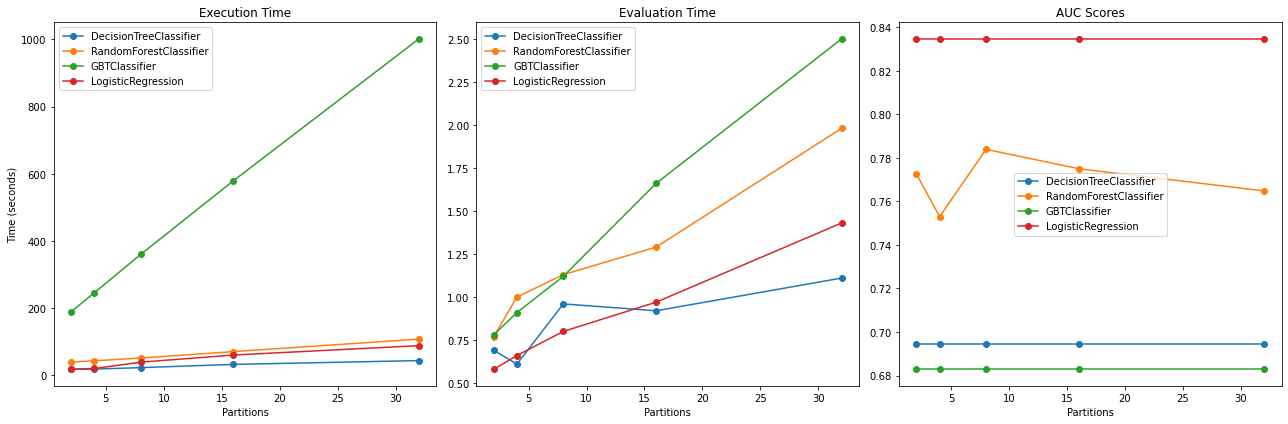

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# DecisionTreeClassifier
partitions_dt = [2, 4, 8, 16, 32]
auc_scores_dt = [0.6944, 0.6944, 0.6944, 0.6944, 0.6944]
exec_times_dt = [17.80, 18.36, 22.68, 32.34, 43.65]
eval_times_dt = [0.69, 0.61, 0.96, 0.92, 1.11]
ax1.plot(partitions_dt, exec_times_dt, 'o-', label='DecisionTreeClassifier')
ax2.plot(partitions_dt, eval_times_dt, 'o-', label='DecisionTreeClassifier')
ax3.plot(partitions_dt, auc_scores_dt, 'o-', label='DecisionTreeClassifier')

# RandomForestClassifier
partitions_rf = [2, 4, 8, 16, 32]
auc_scores_rf = [0.7725, 0.7530, 0.7839, 0.7750, 0.7648]
exec_times_rf = [39.37, 43.06, 51.28, 70.43, 107.47]
eval_times_rf = [0.77, 1.00, 1.13, 1.29, 1.98]
ax1.plot(partitions_rf, exec_times_rf, 'o-', label='RandomForestClassifier')
ax2.plot(partitions_rf, eval_times_rf, 'o-', label='RandomForestClassifier')
ax3.plot(partitions_rf, auc_scores_rf, 'o-', label='RandomForestClassifier')

# GBTClassifier
partitions_gbt = [2, 4, 8, 16, 32]
auc_scores_gbt = [0.6829, 0.6829, 0.6829, 0.6829, 0.6829]
exec_times_gbt = [188.99, 245.37, 359.66, 578.96, 1001.33]
eval_times_gbt = [0.78, 0.91, 1.12, 1.66, 2.50]
ax1.plot(partitions_gbt, exec_times_gbt, 'o-', label='GBTClassifier')
ax2.plot(partitions_gbt, eval_times_gbt, 'o-', label='GBTClassifier')
ax3.plot(partitions_gbt, auc_scores_gbt, 'o-', label='GBTClassifier')

# LogisticRegression
partitions_lr = [2, 4, 8, 16, 32]
auc_scores_lr = [0.8346, 0.8346, 0.8346, 0.8346, 0.8346]
exec_times_lr = [18.07, 20.13, 38.91, 60.18, 88.14]
eval_times_lr = [0.58, 0.66, 0.80, 0.97, 1.43]
ax1.plot(partitions_lr, exec_times_lr, 'o-', label='LogisticRegression')
ax2.plot(partitions_lr, eval_times_lr, 'o-', label='LogisticRegression')
ax3.plot(partitions_lr, auc_scores_lr, 'o-', label='LogisticRegression')

ax1.set_title('Execution Time')
ax1.set_xlabel('Partitions')
ax1.set_ylabel('Time (seconds)')
ax1.legend()

ax2.set_title('Evaluation Time')
ax2.set_xlabel('Partitions')
ax2.legend()

ax3.set_title('AUC Scores')
ax3.set_xlabel('Partitions')
ax3.legend()

plt.tight_layout()
plt.show()
